In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [18]:
data_folder = '../M-CAN Intrusion Dataset/'
print(os.listdir(data_folder))

['g80_mcan_fuzzing_data.csv', 'g80_mcan_ddos_data.csv', 'g80_mcan_normal_data.csv', 'README.txt']


In [19]:
dos_data_path = os.path.join(data_folder,'g80_mcan_ddos_data.csv')
fuzzy_data_path = os.path.join(data_folder, 'g80_mcan_fuzzing_data.csv')
normal_data_path = os.path.join(data_folder, 'g80_mcan_normal_data.csv')

In [20]:
##Function to convert hexadecimal to decimal 
hex_to_dec = lambda x: int(str(x), 16)


def read_data(data_path):
    
    data = pd.read_csv(data_path)    
    
    ## Removing spaces within the payload column entries
    data['Payload'] = data['Payload'].str.replace(' ','')
    
    ## Converting hexadecimal columns to decimals
    data['ID'] = data['ID'].apply(hex_to_dec)
    data['Payload'] = data['Payload'].apply(hex_to_dec)
    return data
    

In [21]:
dos_data = read_data(dos_data_path)
fuzzy_data = read_data(fuzzy_data_path)
normal_data = read_data(normal_data_path)

In [22]:
##Merging datasets
merged_df = pd.concat([dos_data, fuzzy_data, normal_data], axis=0, ignore_index=True)

In [23]:
merged_df.sort_values(by = ['Timestamp'], inplace = True)

##Removing duplicates
merged_df.drop_duplicates(inplace = True)

##Creating IAT feature column
merged_df = merged_df.assign(IAT=merged_df['Timestamp'].diff().fillna(0))

merged_df.drop(columns = ['Timestamp'], inplace = True)

In [24]:
merged_df.head()

,ID,DLC,Payload,label,IAT
0,290,8,9151314442816856063,0.0,0.00000
1217541,829,8,50331648,0.0,0.00957
1217542,1409,8,0,0.0,0.01071
1217543,466,8,16375088258004025344,0.0,0.00122
1217544,1393,8,9151314442816847872,0.0,0.00124


In [25]:
merged_df.shape

(1282700, 5)

In [26]:
merged_df['label'].value_counts()

0.0    817540
1.0    465160
Name: label, dtype: int64

In [27]:
X = merged_df.drop('label', axis = 1)
y = merged_df['label']

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.3)

In [28]:
## Function to create sequencified dataset for LSTM model

def sequencify(dataset, target, start, end, window):
    
    X = []
    y = []
    
    start = start + window 
    
    if end is None:
        end = len(dataset)
        
    for i in range(start, end+1):
        indices = range(i-window, i) 
        X.append(dataset[indices])
        
        indicey = i -1
        y.append(target[indicey])

    return np.array(X), np.array(y)

In [29]:
X_seq, y_seq = sequencify(X.values, y.values, start = 0, end = None, window = 10)

In [30]:

train_samples = int(np.floor(X_seq.shape[0] * 0.7))

X_train_seq = X_seq[:train_samples,:]
y_train_seq = y_seq[:train_samples]

X_test_seq = X_seq[train_samples:,:]
y_test_seq = y_seq[train_samples:]

In [31]:
print(X_train_seq.shape)
print(X_test_seq.shape)

(897883, 10, 4)
(384808, 10, 4)


In [32]:
## Scaling 2D data and sequencified data
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


mean = X_train_seq.mean(axis=0)
std = X_train_seq.std(axis=0)

X_train_seq -= mean
X_train_seq /= std
X_test_seq -= mean
X_test_seq /= std

In [25]:
##MLP

print("-----MLP-------")

mlp = Sequential()
mlp.add(Input(shape = (4)))
mlp.add(Dense(128, activation = 'relu'))
mlp.add(Dense(128, activation = 'relu'))
mlp.add(Dense(4))

mlp.compile(optimizer='adam',
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

es = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)

mlp_hist = mlp.fit(X_train, y_train, epochs=100, callbacks = [es], validation_split=0.2, batch_size = 8192)

-----MLP-------
Train on 719498 samples, validate on 179875 samples
Epoch 1/100
719498/719498 [==============================] - 2s 2us/sample - loss: 0.3588 - accuracy: 0.9313 - val_loss: 0.0482 - val_accuracy: 0.9921
Epoch 2/100
719498/719498 [==============================] - 0s 1us/sample - loss: 0.0280 - accuracy: 0.9924 - val_loss: 0.0173 - val_accuracy: 0.9935
Epoch 3/100
719498/719498 [==============================] - 0s 1us/sample - loss: 0.0146 - accuracy: 0.9939 - val_loss: 0.0124 - val_accuracy: 0.9944
Epoch 4/100
719498/719498 [==============================] - 0s 1us/sample - loss: 0.0117 - accuracy: 0.9945 - val_loss: 0.0106 - val_accuracy: 0.9949
Epoch 5/100
719498/719498 [==============================] - 0s 1us/sample - loss: 0.0104 - accuracy: 0.9950 - val_loss: 0.0096 - val_accuracy: 0.9956
Epoch 6/100
719498/719498 [==============================] - 0s 1us/sample - loss: 0.0095 - accuracy: 0.9957 - val_loss: 0.0090 - val_accuracy: 0.9961
Epoch 7/100
719498/719498 

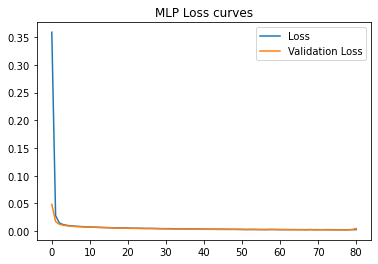

In [26]:
plt.plot(mlp_hist.history['loss'], label = 'Loss')
plt.plot(mlp_hist.history['val_loss'], label = 'Validation Loss')

plt.title('MLP Loss curves')
plt.legend(loc = 'best')
plt.show()

In [27]:
##MLP
print("-----MLP-------")

mlp_preds = mlp.predict(X_test, batch_size = 8196)
mlp_preds = mlp_preds.argmax(axis = 1)

print("ACCURACY: ", accuracy_score(y_test, mlp_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, mlp_preds))

-----MLP-------
ACCURACY:  0.999260596815118
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    246183
         1.0       1.00      1.00      1.00    139263

    accuracy                           1.00    385446
   macro avg       1.00      1.00      1.00    385446
weighted avg       1.00      1.00      1.00    385446



In [28]:
##LSTM

print("-----LSTM-------")

lstm = Sequential()

lstm.add(Input(shape = X_train_seq.shape[1:]))
lstm.add(LSTM(128, activation = 'relu'))
lstm.add(Dense(4, activation = 'softmax'))

lstm.compile(
    loss = SparseCategoricalCrossentropy(from_logits = False),
    optimizer = Adam(learning_rate = 0.001),
    metrics = ['accuracy'])

lstm_hist = lstm.fit(X_train_seq, y_train_seq, batch_size = 8196, validation_split = 0.2,
        callbacks = [es], epochs = 1000)

-----LSTM-------
Train on 719493 samples, validate on 179874 samples
Epoch 1/1000
719493/719493 [==============================] - 9s 12us/sample - loss: 0.3077 - accuracy: 0.9417 - val_loss: 0.0798 - val_accuracy: 0.9863
Epoch 2/1000
719493/719493 [==============================] - 7s 9us/sample - loss: 0.0832 - accuracy: 0.9760 - val_loss: 0.0726 - val_accuracy: 0.9722
Epoch 3/1000
719493/719493 [==============================] - 7s 9us/sample - loss: 0.0493 - accuracy: 0.9867 - val_loss: 0.0225 - val_accuracy: 0.9926
Epoch 4/1000
719493/719493 [==============================] - 7s 9us/sample - loss: 0.0182 - accuracy: 0.9947 - val_loss: 0.0186 - val_accuracy: 0.9931
Epoch 5/1000
719493/719493 [==============================] - 7s 9us/sample - loss: 0.0120 - accuracy: 0.9961 - val_loss: 0.0103 - val_accuracy: 0.9962
Epoch 6/1000
719493/719493 [==============================] - 7s 9us/sample - loss: 0.0553 - accuracy: 0.9897 - val_loss: 0.1502 - val_accuracy: 0.9689
Epoch 7/1000
71949

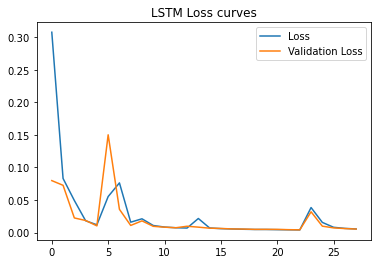

In [29]:
plt.plot(lstm_hist.history['loss'], label = 'Loss')
plt.plot(lstm_hist.history['val_loss'], label = 'Validation Loss')

plt.title('LSTM Loss curves')
plt.legend(loc = 'best')
plt.show()

In [30]:
print("-----LSTM-------")

lstm_preds = lstm.predict(X_test_seq, batch_size=4096)
lstm_preds = lstm_preds.argmax(axis = 1)

print("ACCURACY: ", accuracy_score(y_test_seq, lstm_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test_seq, lstm_preds))

-----LSTM-------
ACCURACY:  0.9988169456962508
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    243082
         1.0       1.00      1.00      1.00    142361

    accuracy                           1.00    385443
   macro avg       1.00      1.00      1.00    385443
weighted avg       1.00      1.00      1.00    385443



In [33]:
## XGBOOST

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)

print("-------XGBOOST-------")
print("ACCURACY: ", accuracy_score(y_test, xgb_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, xgb_preds))


## DECISION TREE

dt = DecisionTreeClassifier(max_depth = 4)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)

print("-------DECISION TREE--------")
print("ACCURACY: ", accuracy_score(y_test, dt_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, dt_preds))


## RANDOM FOREST

rf = RandomForestClassifier(n_estimators=100, max_depth=4)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("-------RANDOM FOREST-------")
print("ACCURACY: ", accuracy_score(y_test, rf_preds))
print("CLASSIFICATION REPORT:\n", classification_report(y_test, rf_preds))

-------XGBOOST-------
ACCURACY:  0.9999688157792157
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    245671
         1.0       1.00      1.00      1.00    139139

    accuracy                           1.00    384810
   macro avg       1.00      1.00      1.00    384810
weighted avg       1.00      1.00      1.00    384810

-------DECISION TREE--------
ACCURACY:  0.9956446038304618
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    245671
         1.0       1.00      0.99      0.99    139139

    accuracy                           1.00    384810
   macro avg       1.00      0.99      1.00    384810
weighted avg       1.00      1.00      1.00    384810

-------RANDOM FOREST-------
ACCURACY:  0.9985603284737923
CLASSIFICATION REPORT:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    245